In [25]:
import matplotlib.pyplot as plt
import numpy as np

from core import *
import imageio.v3 as iio
from PIL import Image

im = iio.imread('800px-SheppLogan.png')

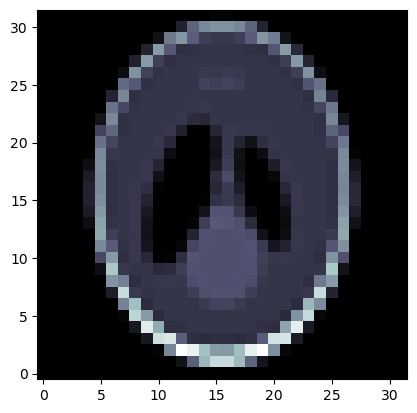

In [26]:
# loading image
new_res = 32

img = Image.fromarray(im).resize((new_res, new_res))
img = np.array(img.convert('L'))
plt.imshow(img, cmap='bone', origin='lower');

In [27]:
params = {
  "no_of_detectors": 32,
  "source_to_object": 100,
  "source_to_detector": 200,
  "size_of_object": 20,
  "no_of_rotations": 64,
  "detector_aperture": 2,
  "resolution": new_res
}

In [28]:
%%timeit
A = CreateInterceptMatrix(**params).create_intercept_matrix_from_lines()

5.84 s ± 695 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Forward Problem

solving the forward problem of obtaining detector readings using image matrix (shepp Logan)

In [29]:
x = img
x.shape

(32, 32)

In [30]:
A.shape

(2048, 1024)

In [31]:
b = A @ x.flatten()
b.shape

(2048,)

## Backward Problem

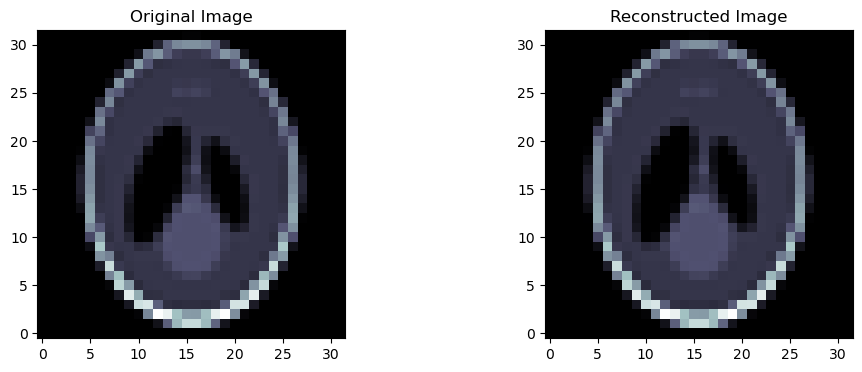

In [32]:
x = SolveEquation(A, b).solve(useLibrary='lstsq')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

reconstructed_img = GenerateImage(x)
reconstructed_img.make_figure(ax=axes[1])
axes[0].imshow(img, origin='lower', cmap='bone')
axes[0].set_title('Original Image')
axes[1].set_title('Reconstructed Image');